# Air Pollution by Politics

## Imports & Installs

In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json
from scipy.signal import argrelextrema

import sys
sys.path.append('../etc')
from refs import state_abbreviation_dict

! pip install xlrd
! pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Loads

Since the `data` folder is approximately **14 GB**, it has been uploaded to a **shared Google Drive folder**.
To access and use this data in this notebook, follow these steps:

---

### 1. Upload this notebook to **Google Colab**
- Open [Google Colab](https://colab.research.google.com/).
- Click on **File → Upload notebook** and select this notebook.

### 2. Mount your Google Drive
Insert and run the following code in a new Colab cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```
- This will prompt you to authorize access to your Google Drive.

### 3. Create a Shortcut of the `data` Folder in Your Google Drive
- Open the shared Google Drive link.
- **Right-click** the `data` folder → **Add shortcut to Drive**.
- Choose a location inside your **MyDrive** (e.g., directly under "MyDrive" or inside a project folder).

### 4. Update the File Paths in the Notebook
When reading the data files, adjust the paths in your code to point to your shortcut location.
For example:

```python
import pandas as pd

# Example
presidential_data = pd.read_csv('/content/drive/MyDrive/your_folder_name/data/election/relevant/usa/1976-2020-president.csv')
```

Replace `your_folder_name` with the actual folder name where you added the shortcut.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# presidential_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-president.csv')
# senate_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-senate.csv')
# house_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2022-house.csv')
# house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')
#
# state_emissions_data = pd.read_excel(
#     "/content/drive/MyDrive/School/data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
#     engine="openpyxl",
#     skiprows=4
# )
#
# state_population_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/population_data.csv')
# state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
# state_land_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/state_sizes.csv')

In [4]:
presidential_data = pd.read_csv('../data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('../data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('../data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "../data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('../data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('../data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [5]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [6]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


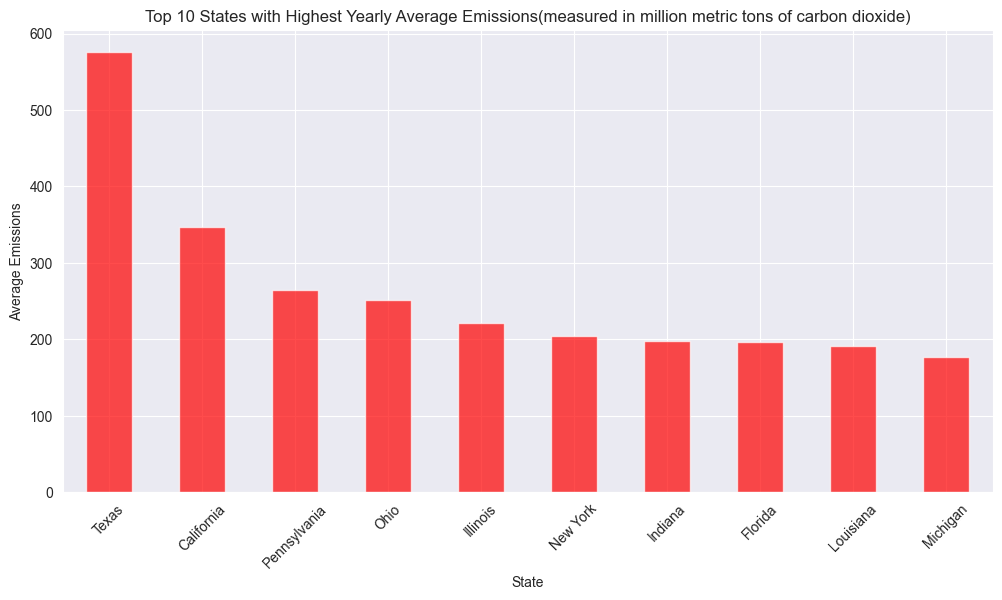

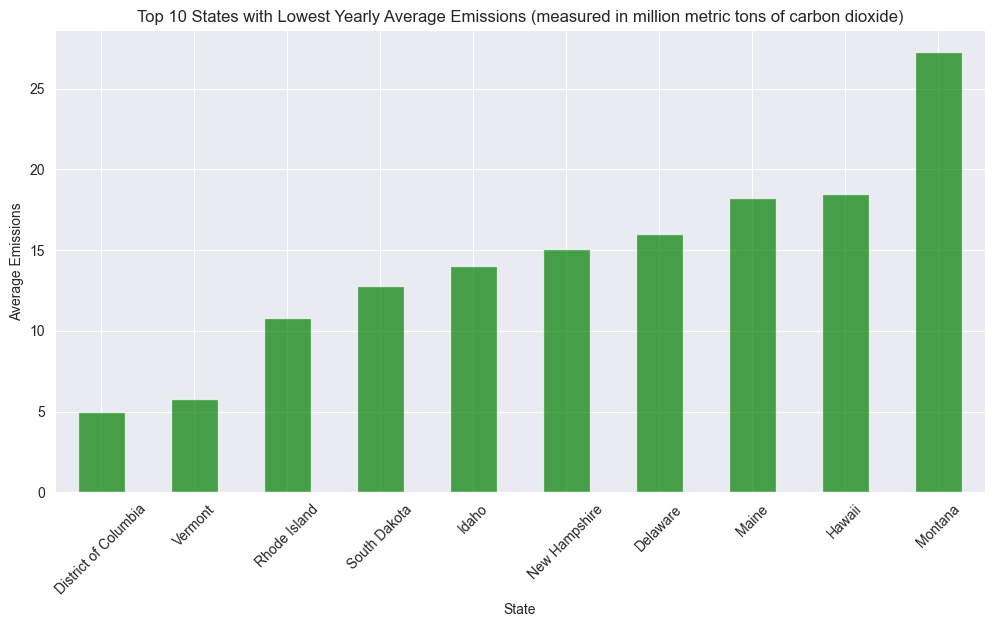

In [7]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Yearly Average Emissions(measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Yearly Average Emissions (measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [8]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [9]:
def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    # Remove rows that contain non-state information (like metadata or NaNs)
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]

    # Remove metadata rows that are not actual state names
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]

    # Get the top and bottom states based on average emissions over time
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    # Filter data for the top and bottom states
    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            # Plot all local minima
            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')

            # Plot all local maxima
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Max label with party affiliation score
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()  # To ensure everything fits well without overlap
        plt.show()

    # Run the plot functions
    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)

In [10]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


In [11]:
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


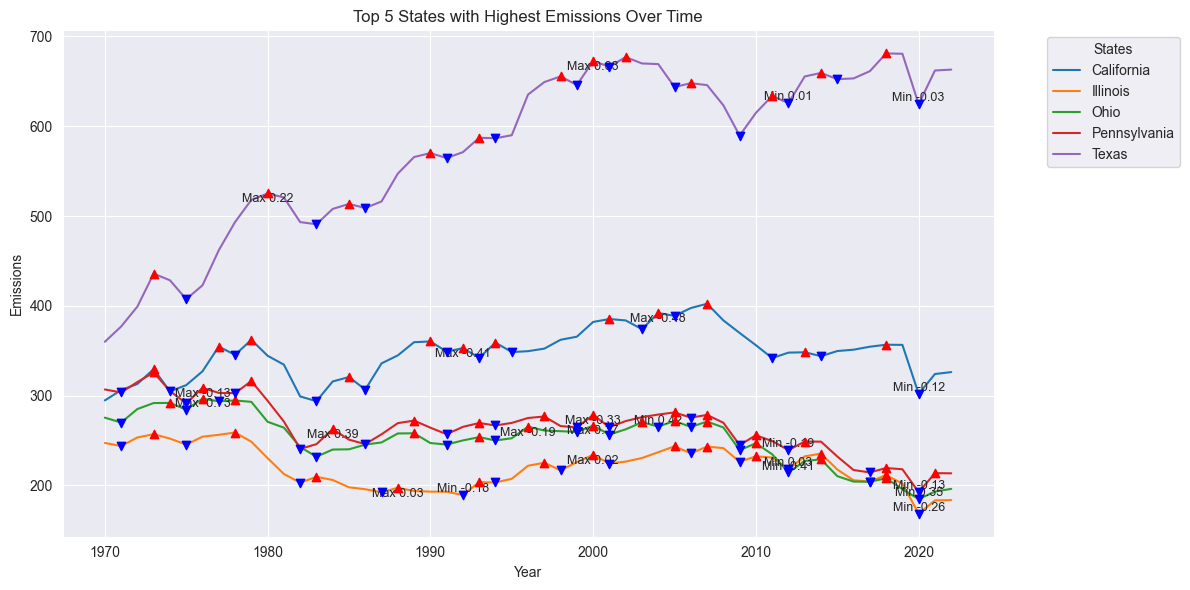

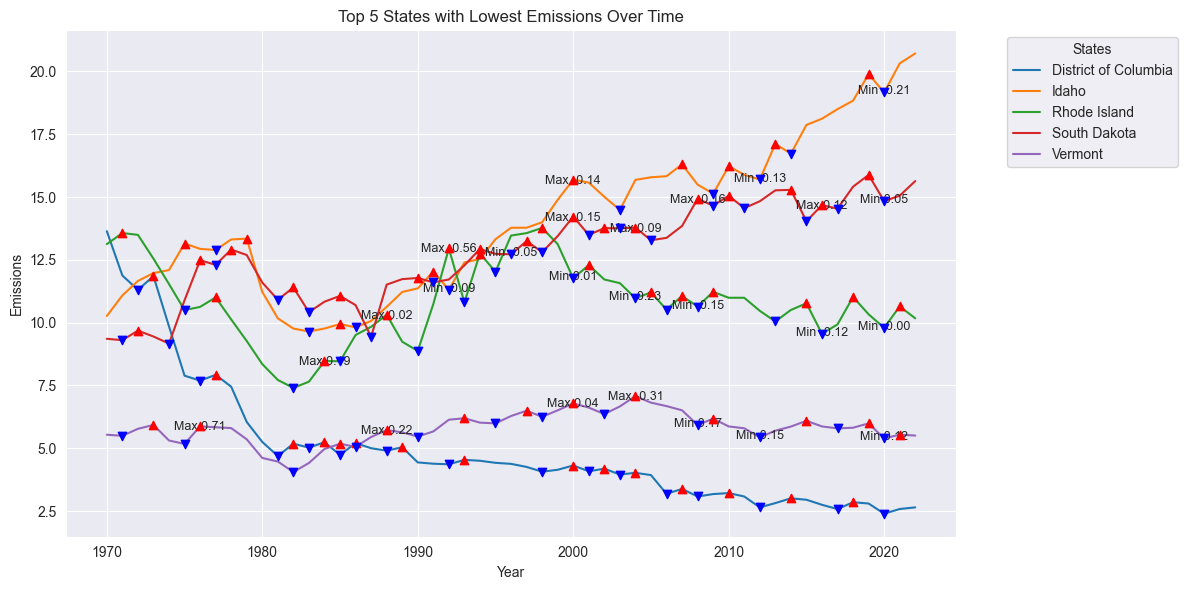

In [12]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [13]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [14]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [15]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [16]:
election_scores_df = pd.read_csv('../data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [17]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [18]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

final_df_imputed, final_df_dropped

(     Policy Scores state    year   emissions  population     size  \
 0        27.000440    AL  1980.0  107.172609   3900368.0  52420.0   
 1        42.097413    AL  1984.0   95.389801   3951820.0  52420.0   
 2        42.097413    AL  1988.0  105.221571   4023844.0  52420.0   
 3        27.183586    AL  1992.0  120.975301   4139269.0  52420.0   
 4        17.721870    AL  1996.0  137.217372   4290403.0  52420.0   
 ..             ...   ...     ...         ...         ...      ...   
 578       7.146112    WY  2004.0   64.383683    509106.0  97813.0   
 579       3.146390    WY  2008.0   67.222540    546043.0  97813.0   
 580      14.832834    WY  2012.0   66.647098    576656.0  97813.0   
 581      12.360478    WY  2016.0   61.035090    585243.0  97813.0   
 582       5.390857    WY  2020.0   55.385165    577681.0  97813.0   
 
      party_affiliation_score  
 0                   0.707140  
 1                   0.365180  
 2                   0.121370  
 3                   0.225649 

In [19]:
def fill_missing_years(df):
    df['year'] = df['year'].astype(int)
    max_year = min(df['year'].max(), 2024)
    full_years = pd.DataFrame({'year': range(df['year'].min(), max_year + 1)})
    states = df['state'].unique()
    filled_df = []

    for state in states:
        state_df = df[df['state'] == state]
        state_df = pd.merge(full_years, state_df, on='year', how='left')
        state_df['state'] = state
        for col in ['Policy Scores', 'emissions', 'population', 'size', 'party_affiliation_score']:
            state_df[col] = state_df[col].interpolate(method='linear', limit_direction='both')
        filled_df.append(state_df)

    return pd.concat(filled_df).reset_index(drop=True)

In [20]:
final_df_imputed = fill_missing_years(final_df_imputed)
final_df_imputed

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,1976,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
1,1977,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
2,1978,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
3,1979,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
4,1980,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
...,...,...,...,...,...,...,...
2245,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
2246,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
2247,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
2248,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


In [21]:
final_df_dropped = fill_missing_years(final_df_dropped)
final_df_dropped

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,2004,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
1,2005,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
2,2006,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
3,2007,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
4,2008,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
...,...,...,...,...,...,...,...
624,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
625,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
626,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
627,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

In [23]:
final_df_imputed_normalized

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,1976,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140
1,1977,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140
2,1978,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140
3,1979,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140
4,1980,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140
...,...,...,...,...,...,...,...
2245,2016,-0.288220,WY,61.035090,-0.808000,0.227085,-0.280461
2246,2017,-0.368379,WY,59.622609,-0.808312,0.227085,-0.287553
2247,2018,-0.448537,WY,58.210128,-0.808624,0.227085,-0.294644
2248,2019,-0.528696,WY,56.797646,-0.808936,0.227085,-0.301735


In [24]:
final_df_dropped_normalized

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,2004,-0.576684,AL,139.355377,-0.227362,-0.297275,-0.108467
1,2005,-0.576684,AL,139.355377,-0.227362,-0.297275,-0.108467
2,2006,-0.576684,AL,139.355377,-0.227362,-0.297275,-0.108467
3,2007,-0.576684,AL,139.355377,-0.227362,-0.297275,-0.108467
4,2008,-0.576684,AL,139.355377,-0.227362,-0.297275,-0.108467
...,...,...,...,...,...,...,...
624,2016,-0.279498,WY,61.035090,-0.788170,0.120018,-0.280461
625,2017,-0.329346,WY,59.622609,-0.788426,0.120018,-0.287553
626,2018,-0.379194,WY,58.210128,-0.788683,0.120018,-0.294644
627,2019,-0.429043,WY,56.797646,-0.788939,0.120018,-0.301735


In [25]:
final_df_dropped_normalized = pd.get_dummies(final_df_dropped_normalized, columns=['state'])
final_df_dropped = pd.get_dummies(final_df_dropped, columns=['state'])

final_df_imputed_normalized = pd.get_dummies(final_df_imputed_normalized, columns=['state'])
final_df_imputed = pd.get_dummies(final_df_imputed, columns=['state'])

This code applies one-hot encoding to the "state" column in the `final_df_imputed` DataFrame using the `pd.get_dummies()` function. This transforms the categorical "state" column into multiple binary (0 or 1) columns, each representing a different state. The resulting `final_df_imputed` DataFrame contains the original data along with the new binary columns for each state. Each column indicates whether the data corresponds to a specific state, allowing for easier inclusion in machine learning models.

Emissions initially declined, then rose steadily until the early 2000s, after which they began a continuous downward trend.

    year   emissions
0   1976   94.506645
1   1977   94.666194
2   1978   94.825743
3   1979   94.985293
4   1980   95.144842
5   1981   94.341183
6   1982   93.537525
7   1983   92.733866
8   1984   91.930208
9   1985   93.865621
10  1986   95.801035
11  1987   97.736448
12  1988   99.671862
13  1989  100.075941
14  1990  100.480021
15  1991  100.884100
16  1992  101.288180
17  1993  103.429000
18  1994  105.569820
19  1995  107.710640
20  1996  109.851460
21  1997  111.667908
22  1998  113.484357
23  1999  115.300806
24  2000  117.117254
25  2001  117.590448
26  2002  118.063642
27  2003  118.536837
28  2004  119.010031
29  2005  118.229733
30  2006  117.449435
31  2007  116.669137
32  2008  115.888839
33  2009  112.981748
34  2010  110.074656
35  2011  107.167564
36  2012  104.260472
37  2013  103.929909
38  2014  103.599346
39  2015  103.268783
40  2016  102.938219
41  2017  100.051559
42  2018   97.164898
43  2019   94.278237
44  2020   91.391576


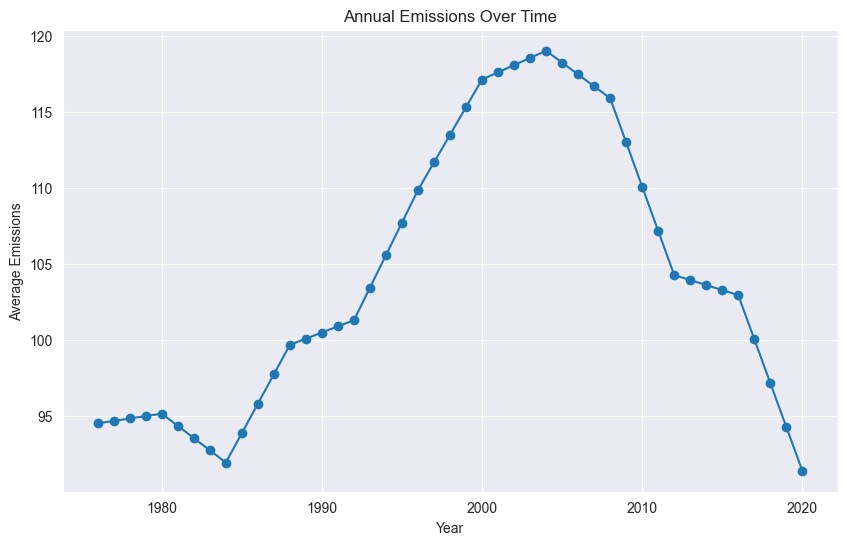

In [26]:
# Group emissions by year and calculate the mean
emissions_by_year = final_df_imputed_normalized.groupby('year')['emissions'].mean().reset_index()

# Display the table
print(emissions_by_year)

# Plot emissions over time
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year['year'], emissions_by_year['emissions'], marker='o')
plt.title('Annual Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Emissions')
plt.grid(True)
plt.show()

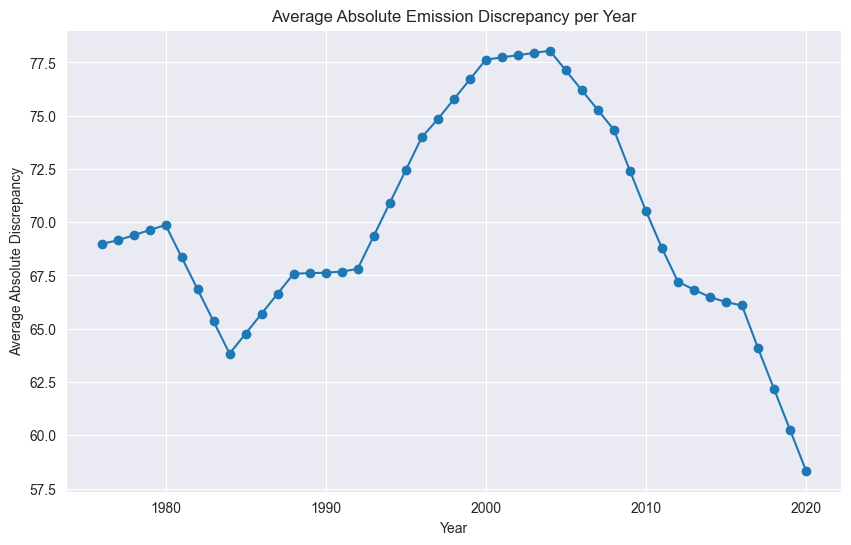

In [27]:
# Step 1: Calculate overall mean emissions per year
overall_yearly_mean = final_df_imputed_normalized.groupby('year')['emissions'].mean().rename('overall_mean')

# Step 2: Merge the overall mean back to the original DataFrame
df_with_discrepancy = final_df_imputed_normalized.merge(overall_yearly_mean, left_on='year', right_index=True)

# Step 3: Calculate discrepancy per state per year
df_with_discrepancy['discrepancy'] = df_with_discrepancy['emissions'] - df_with_discrepancy['overall_mean']

# Step 4: Calculate the average absolute discrepancy per year
avg_abs_discrepancy_per_year = (
    df_with_discrepancy.groupby('year')['discrepancy']
    .apply(lambda x: x.abs().mean())
    .reset_index(name='avg_abs_discrepancy')
)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_abs_discrepancy_per_year['year'], avg_abs_discrepancy_per_year['avg_abs_discrepancy'], marker='o')
plt.title('Average Absolute Emission Discrepancy per Year')
plt.xlabel('Year')
plt.ylabel('Average Absolute Discrepancy')
plt.grid(True)
plt.show()

## Final Analysis

### Current Emissions Predictions

This code trains a Random Forest model to predict emissions using various features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. It splits the data into training and testing sets, trains the model, and makes predictions on the test set. The Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time of the process is also recorded and printed. The final output includes the MSE and the time taken to train and test the model.

In [28]:
def train_rf_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    feature_importance = rf_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    return mse, r2, elapsed_time, feature_importance_df

#### Imputed

In [30]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_rf_model(final_df_imputed)

Mean Squared Error: 48.21838989883085
R² Score: 0.9960319288780504
Time taken: 0.5841729640960693 seconds

Feature Importance:
                    Feature    Importance
1                population  7.226461e-01
2                      size  1.298358e-01
46                 state_TX  7.846568e-02
18                 state_IN  1.531670e-02
21                 state_LA  1.487354e-02
8                  state_CA  1.047584e-02
25                 state_MI  4.591755e-03
52                 state_WV  3.853248e-03
0             Policy Scores  3.617533e-03
3   party_affiliation_score  2.451623e-03
54          political_party  2.389001e-03
39                 state_OK  1.744198e-03
40                 state_OR  1.543651e-03
53                 state_WY  1.080257e-03
51                 state_WI  1.075576e-03
31                 state_ND  7.339128e-04
34                 state_NJ  4.756604e-04
16                 state_ID  3.846169e-04
48                 state_VA  3.544903e-04
15                 state_IA  3.38

#### Non-imputed

In [31]:
mse_dropped, r2_dropped, elapsed_time_dropped, feature_importance_dropped = train_rf_model(final_df_dropped)

Mean Squared Error: 16.497797117096027
R² Score: 0.9981807249732024
Time taken: 0.17345690727233887 seconds

Feature Importance:
                    Feature    Importance
1                population  8.799633e-01
2                      size  3.314428e-02
34                 state_TX  3.087258e-02
0             Policy Scores  1.408549e-02
17                 state_IN  1.148086e-02
8                  state_CA  9.402612e-03
3   party_affiliation_score  6.655882e-03
41          political_party  5.164259e-03
30                 state_OK  2.088137e-03
13                 state_GA  2.021884e-03
31                 state_OR  1.571639e-03
40                 state_WY  7.032481e-04
16                 state_ID  6.353038e-04
24                 state_MO  3.875331e-04
15                 state_IA  3.688971e-04
39                 state_WI  2.640520e-04
27                 state_NE  2.138375e-04
28                 state_NV  2.095070e-04
37                 state_VT  1.308714e-04
10                 state_CT  1.

This code trains a Gradient Boosting model to predict emissions using features like "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. The data is split into training and testing sets, and the model is trained using the training data. After making predictions on the test set, the Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time for training and testing the model is also recorded and printed. The output includes the MSE and the time taken to complete the process.

In [32]:
def train_gb_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    state_columns = df.columns[6:]
    columns_to_select = ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)

    X = df[columns_to_select]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    feature_importance = gb_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    return mse, r2, elapsed_time, feature_importance_df

#### Imputed

In [33]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_gb_model(final_df_imputed)

Mean Squared Error: 184.43454262072726
R² Score: 0.9848221936900252
Time taken: 0.2345590591430664 seconds

Feature Importance:
                    Feature  Importance
1                population    0.721347
46                 state_TX    0.115098
2                      size    0.106749
21                 state_LA    0.015799
18                 state_IN    0.015721
52                 state_WV    0.004398
0             Policy Scores    0.002981
8                  state_CA    0.002352
41                 state_PA    0.002235
37                 state_NY    0.001794
40                 state_OR    0.001748
53                 state_WY    0.001451
20                 state_KY    0.001136
50                 state_WA    0.001040
38                 state_OH    0.000789
54          political_party    0.000718
16                 state_ID    0.000580
39                 state_OK    0.000538
48                 state_VA    0.000485
44                 state_SD    0.000424
51                 state_WI    0

#### Non-imputed

In [34]:
mse_dropped, r2_dropped, elapsed_time_dropped, feature_importance_dropped = train_gb_model(final_df_dropped)

Mean Squared Error: 50.15149389685387
R² Score: 0.9944696034412625
Time taken: 0.06543612480163574 seconds

Feature Importance:
                    Feature  Importance
1                population    0.888881
2                      size    0.039608
34                 state_TX    0.015659
0             Policy Scores    0.014235
17                 state_IN    0.011889
8                  state_CA    0.010696
13                 state_GA    0.006624
30                 state_OK    0.002243
41          political_party    0.002232
3   party_affiliation_score    0.001690
16                 state_ID    0.001134
19                 state_KY    0.001003
31                 state_OR    0.000848
40                 state_WY    0.000754
38                 state_WA    0.000680
24                 state_MO    0.000679
5                  state_AL    0.000308
18                 state_KS    0.000232
39                 state_WI    0.000206
29                 state_OH    0.000159
37                 state_VT    0

### Future Predictions

This code splits the data into 10-year intervals and trains a Random Forest model to predict emissions for each interval. It calculates predictions and compares them with actual emissions, evaluating the model's performance using Mean Squared Error (MSE) and R² score. The actual and predicted emissions are plotted over the years, and the model performance metrics are displayed. The final output is a DataFrame showing the actual and predicted emissions for each year.

In [35]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error
#
# def train_random_forest(df, n):
#     try:
#         if df['year'].dtype == 'object' or df['year'].dtype == 'int64':
#             df['year'] = pd.to_datetime(df['year'], errors='coerce')
#
#         state_columns = [col for col in df.columns if col.startswith('state_')]
#         if not state_columns:
#             print("No state columns found!")
#             return
#
#         print(f"State columns: {state_columns}")
#
#         df['state'] = df[state_columns].idxmax(axis=1).str.replace('state_', '', regex=False)
#         df = df.sort_values(['state', 'year'])
#
#         df['y_shifted'] = df.groupby('state')['emissions'].shift(-n)
#         print(f"Shape after shifting: {df.shape}")
#
#         df = df.dropna(subset=['y_shifted'])
#         print(f"Shape after dropping NaNs: {df.shape}")
#
#         if df.shape[0] == 0:
#             print("After dropping NaN values, the dataset is empty.")
#             return
#
#         features = ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + state_columns
#         X = df[features]
#         y = df['y_shifted']
#
#         if X.shape[0] == 0:
#             print("Features dataset is empty!")
#             return
#
#         print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
#
#         # Perform train-test split
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
#         print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")
#         print(f"Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")
#
#         if X_train.shape[0] == 0 or X_test.shape[0] == 0:
#             print("After train-test split, there are no samples in train or test.")
#             return
#
#         # Train RandomForestRegressor
#         rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#         rf_model.fit(X_train, y_train)
#
#         print("Model training completed.")
#
#         # Make predictions
#         y_pred = rf_model.predict(X_test)
#
#         r2 = r2_score(y_test, y_pred)
#         print(f'R² Score: {r2}')
#
#         mse = mean_squared_error(y_test, y_pred)
#         print(f'Mean Squared Error: {mse}')
#
#         selected_states = df['state'].unique()[:3]
#         plt.figure(figsize=(10, 6))
#
#         for state in selected_states:
#             state_data = df[df['state'] == state]
#             plt.plot(state_data['year'], state_data['emissions'], label=f'Actual Emissions ({state})', linestyle='--', alpha=0.7)
#             plt.plot(state_data['year'], state_data['y_shifted'], label=f'Predicted Emissions ({state})', alpha=0.7)
#
#         plt.xlabel('Year')
#         plt.ylabel('Emissions')
#         plt.title('Predicted vs Actual Emissions Over Time for 3 States')
#         plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.tight_layout()
#         plt.show()
#
#         feature_importances = rf_model.feature_importances_
#         for feature, importance in zip(features, feature_importances):
#             print(f'Feature: {feature}, Importance: {importance}')
#
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")
#         print("Debugging details:")
#         print(f"DataFrame shape before: {df.shape}")
#         print(f"Columns: {df.columns}")
#         print(f"n (shift): {n}")


In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def train_random_forest(df, window_size):
    try:
        # Ensure 'year' is numeric (remove datetime issue)
        df['year'] = pd.to_numeric(df['year'], errors='coerce')

        # Identify one-hot encoded state columns
        state_columns = [col for col in df.columns if col.startswith('state_')]
        if not state_columns:
            print("No state columns found!")
            return

        print(f"State columns: {state_columns}")

        # Extract 'state' from one-hot encoded columns
        df['state'] = df[state_columns].idxmax(axis=1).str.replace('state_', '', regex=False)
        df = df.sort_values(['state', 'year'])

        # Create lag features for sliding window
        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()

        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        # Build feature list
        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['Policy Scores', 'population', 'size', 'party_affiliation_score'] + state_columns

        X = df[features]
        y = df['emissions']

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

        # Train model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f'R² Score: {r2:.4f}')
        print(f'Mean Squared Error: {mse:.4f}')

        # Plot actual emissions for 3 example states
        selected_states = df['state'].unique()[:3]
        plt.figure(figsize=(10, 6))

        for state in selected_states:
            state_data = df[df['state'] == state]
            plt.plot(state_data['year'], state_data['emissions'], label=f'Actual Emissions ({state})', linestyle='--', alpha=0.7)

        plt.xlabel('Year')
        plt.ylabel('Emissions')
        plt.title('Actual Emissions Over Time for 3 States')
        plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Feature importances
        feature_importances = rf_model.feature_importances_
        for feature, importance in zip(features, feature_importances):
            print(f'Feature: {feature}, Importance: {importance:.4f}')

        return r2, mse, pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Debugging details:")
        print(f"DataFrame shape before: {df.shape}")
        print(f"Columns: {df.columns}")
        print(f"window_size: {window_size}")


In [37]:
final_df_imputed

,year,Policy Scores,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,political_party
0,1976,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2175
1,1977,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2175
2,1978,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2175
3,1979,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2175
4,1980,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,2016,-0.288220,61.035090,-0.808000,0.227085,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,0,1,322
2246,2017,-0.368379,59.622609,-0.808312,0.227085,-0.287553,0,0,0,0,...,0,0,0,0,0,0,0,0,1,309
2247,2018,-0.448537,58.210128,-0.808624,0.227085,-0.294644,0,0,0,0,...,0,0,0,0,0,0,0,0,1,294
2248,2019,-0.528696,56.797646,-0.808936,0.227085,-0.301735,0,0,0,0,...,0,0,0,0,0,0,0,0,1,273


#### Imputed

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after sliding window processing: (2200, 59)
Training samples: 1760, Testing samples: 440
R² Score: 0.9989
Mean Squared Error: 12.9113


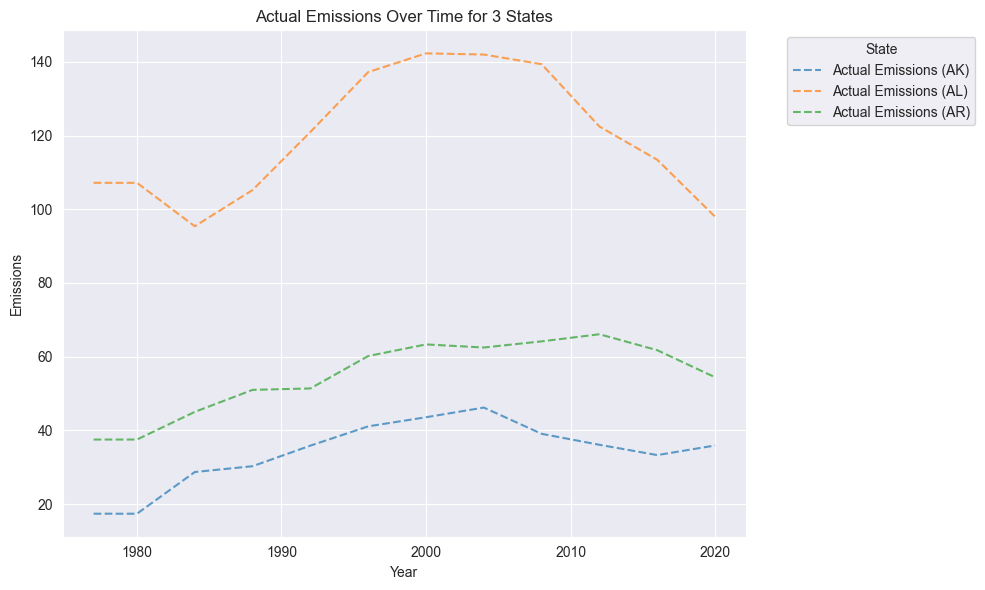

Feature: emissions_t_minus_1, Importance: 0.8679
Feature: Policy Scores, Importance: 0.0012
Feature: population, Importance: 0.0048
Feature: size, Importance: 0.0619
Feature: party_affiliation_score, Importance: 0.0003
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0016
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: state_HI, Importance: 0.0000
Feature: state_IA, Importance: 0.0000
Feature: state_ID, Importance: 0.0000
Feature: state_IL, Importance: 0.0000
Feature: state_IN, Importance: 0.0000
Feature: state_KS, Importance: 0.0000
Feature: state_KY, Importance: 0.0000
Feature: state_LA, Importance: 0.0000
Feature: state_MA, Importance: 0.0000
Feature: state_MD, Importance: 0.0000
Feature: state_ME, Im

(0.9989296029900969,
 12.911296144135871,
                     Feature    Importance
 0       emissions_t_minus_1  8.679397e-01
 47                 state_TX  6.227803e-02
 3                      size  6.191929e-02
 2                population  4.768889e-03
 9                  state_CA  1.551592e-03
 1             Policy Scores  1.210838e-03
 4   party_affiliation_score  2.765961e-04
 42                 state_PA  7.445131e-06
 13                 state_FL  6.887532e-06
 39                 state_OH  5.756857e-06
 14                 state_GA  4.370225e-06
 18                 state_IL  4.127429e-06
 6                  state_AL  2.197534e-06
 50                 state_VT  2.145017e-06
 31                 state_NC  1.989386e-06
 38                 state_NY  1.981199e-06
 19                 state_IN  1.738737e-06
 46                 state_TN  1.418335e-06
 49                 state_VA  1.388908e-06
 8                  state_AZ  1.034400e-06
 48                 state_UT  9.633241e-07
 51         

In [38]:
train_random_forest(final_df_imputed, 1)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after sliding window processing: (2000, 63)
Training samples: 1600, Testing samples: 400
R² Score: 0.9995
Mean Squared Error: 6.1294


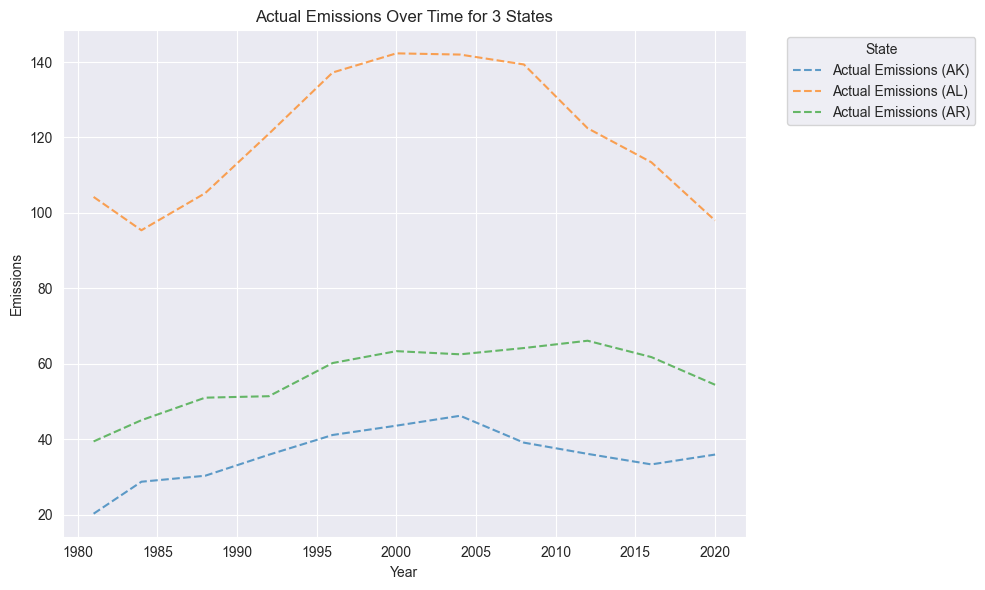

Feature: emissions_t_minus_5, Importance: 0.0334
Feature: emissions_t_minus_4, Importance: 0.0353
Feature: emissions_t_minus_3, Importance: 0.0308
Feature: emissions_t_minus_2, Importance: 0.0300
Feature: emissions_t_minus_1, Importance: 0.7810
Feature: Policy Scores, Importance: 0.0005
Feature: population, Importance: 0.0024
Feature: size, Importance: 0.0485
Feature: party_affiliation_score, Importance: 0.0001
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0018
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: state_HI, Importance: 0.0000
Feature: state_IA, Importance: 0.0000
Feature: state_ID, Importance: 0.0000
Feature: state_IL, Importance: 0.0000
Feature: state_IN, Importance: 0.0000
Feature: state_

(0.9994643396943321,
 6.129421445766634,
                     Feature    Importance
 4       emissions_t_minus_1  7.809967e-01
 7                      size  4.853505e-02
 51                 state_TX  3.612926e-02
 1       emissions_t_minus_4  3.529865e-02
 0       emissions_t_minus_5  3.337450e-02
 2       emissions_t_minus_3  3.082617e-02
 3       emissions_t_minus_2  2.999321e-02
 6                population  2.407118e-03
 13                 state_CA  1.766177e-03
 5             Policy Scores  5.250528e-04
 8   party_affiliation_score  1.176073e-04
 46                 state_PA  1.072168e-05
 18                 state_GA  2.507596e-06
 17                 state_FL  1.880409e-06
 54                 state_VT  1.759804e-06
 22                 state_IL  1.587471e-06
 43                 state_OH  1.277445e-06
 42                 state_NY  8.763273e-07
 30                 state_MI  8.137164e-07
 35                 state_NC  7.447803e-07
 23                 state_IN  6.842131e-07
 52          

In [39]:
train_random_forest(final_df_imputed, 5)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY']
Shape after sliding window processing: (1800, 67)
Training samples: 1440, Testing samples: 360
R² Score: 0.9994
Mean Squared Error: 6.2532


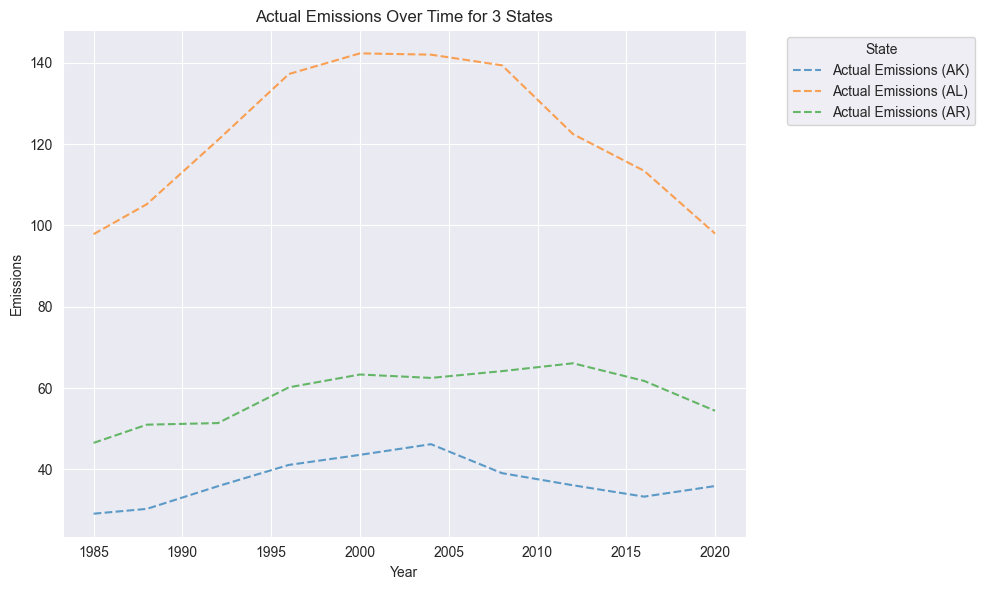

Feature: emissions_t_minus_9, Importance: 0.0282
Feature: emissions_t_minus_8, Importance: 0.0244
Feature: emissions_t_minus_7, Importance: 0.0350
Feature: emissions_t_minus_6, Importance: 0.0187
Feature: emissions_t_minus_5, Importance: 0.0115
Feature: emissions_t_minus_4, Importance: 0.0085
Feature: emissions_t_minus_3, Importance: 0.0227
Feature: emissions_t_minus_2, Importance: 0.0350
Feature: emissions_t_minus_1, Importance: 0.7178
Feature: Policy Scores, Importance: 0.0002
Feature: population, Importance: 0.0063
Feature: size, Importance: 0.0456
Feature: party_affiliation_score, Importance: 0.0001
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0037
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: 

(0.9994113531622246,
 6.253202053832928,
                 Feature    Importance
 8   emissions_t_minus_1  7.178061e-01
 11                 size  4.562393e-02
 55             state_TX  4.240480e-02
 2   emissions_t_minus_7  3.499570e-02
 7   emissions_t_minus_2  3.498040e-02
 ..                  ...           ...
 42             state_NH  1.769412e-08
 13             state_AK  1.705988e-08
 25             state_ID  6.508079e-09
 51             state_RI  2.437535e-09
 53             state_SD  1.643554e-09
 
 [63 rows x 2 columns])

In [40]:
train_random_forest(final_df_imputed, 9)

#### Non-imputed

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after sliding window processing: (592, 46)
Training samples: 473, Testing samples: 119
R² Score: 0.9971
Mean Squared Error: 38.4956


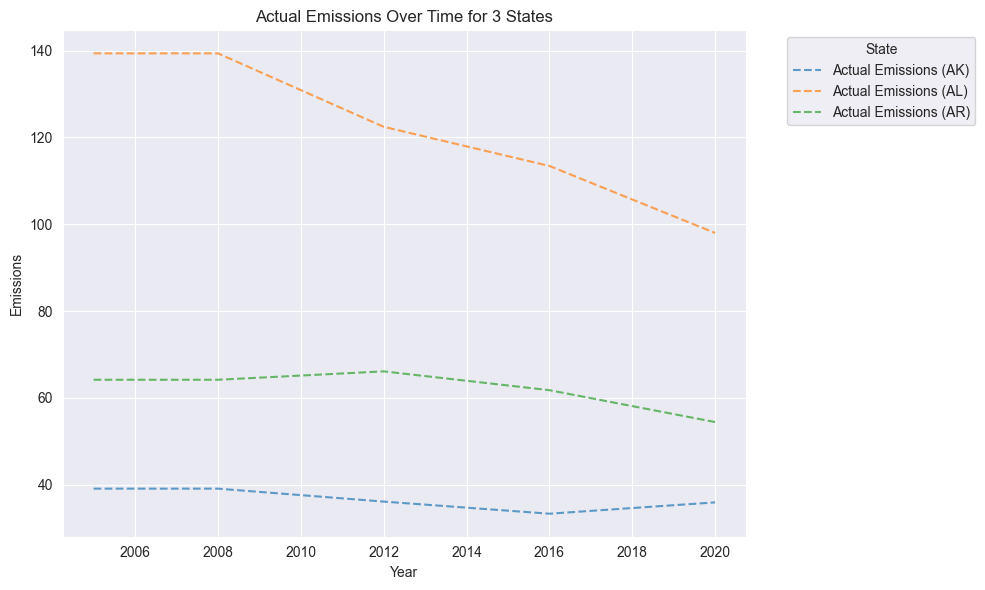

Feature: emissions_t_minus_1, Importance: 0.7452
Feature: Policy Scores, Importance: 0.0078
Feature: population, Importance: 0.1793
Feature: size, Importance: 0.0243
Feature: party_affiliation_score, Importance: 0.0048
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0083
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: state_HI, Importance: 0.0000
Feature: state_IA, Importance: 0.0000
Feature: state_ID, Importance: 0.0000
Feature: state_IN, Importance: 0.0000
Feature: state_KS, Importance: 0.0000
Feature: state_KY, Importance: 0.0000
Feature: state_MA, Importance: 0.0000
Feature: state_MD, Importance: 0.0000
Feature: state_ME, Importance: 0.0000
Feature: state_MN, Importance: 0.0000
Feature: state_MO, Im

(0.9971089547564093,
 38.49556843484348,
                     Feature    Importance
 0       emissions_t_minus_1  7.451556e-01
 2                population  1.793464e-01
 35                 state_TX  3.019147e-02
 3                      size  2.428104e-02
 9                  state_CA  8.269365e-03
 1             Policy Scores  7.829137e-03
 4   party_affiliation_score  4.812652e-03
 38                 state_VT  8.642539e-05
 14                 state_GA  6.628003e-06
 33                 state_PA  2.985901e-06
 28                 state_NE  2.547328e-06
 27                 state_MT  2.400904e-06
 30                 state_OH  2.241213e-06
 13                 state_FL  1.853361e-06
 18                 state_IN  1.750661e-06
 20                 state_KY  1.395085e-06
 37                 state_VA  6.528864e-07
 32                 state_OR  5.627944e-07
 34                 state_TN  5.548350e-07
 21                 state_MA  5.037577e-07
 6                  state_AL  4.996230e-07
 31          

In [41]:
train_random_forest(final_df_dropped, 1)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after sliding window processing: (555, 47)
Training samples: 444, Testing samples: 111
R² Score: 0.9962
Mean Squared Error: 23.0182


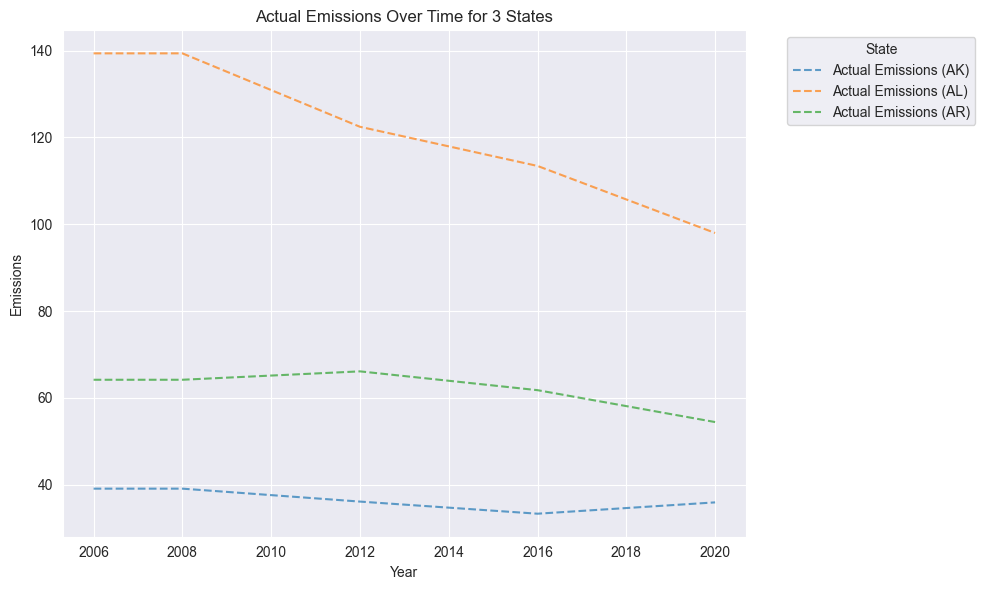

Feature: emissions_t_minus_2, Importance: 0.3359
Feature: emissions_t_minus_1, Importance: 0.4476
Feature: Policy Scores, Importance: 0.0067
Feature: population, Importance: 0.1689
Feature: size, Importance: 0.0130
Feature: party_affiliation_score, Importance: 0.0048
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0143
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: state_HI, Importance: 0.0000
Feature: state_IA, Importance: 0.0000
Feature: state_ID, Importance: 0.0000
Feature: state_IN, Importance: 0.0000
Feature: state_KS, Importance: 0.0000
Feature: state_KY, Importance: 0.0000
Feature: state_MA, Importance: 0.0000
Feature: state_MD, Importance: 0.0000
Feature: state_ME, Importance: 0.0000
Feature: s

(0.9962111735830158,
 23.01818931494309,
                     Feature    Importance
 1       emissions_t_minus_1  4.476237e-01
 0       emissions_t_minus_2  3.359097e-01
 3                population  1.688583e-01
 10                 state_CA  1.433557e-02
 4                      size  1.301188e-02
 36                 state_TX  8.682467e-03
 2             Policy Scores  6.694985e-03
 5   party_affiliation_score  4.776453e-03
 39                 state_VT  8.280418e-05
 28                 state_MT  3.706631e-06
 34                 state_PA  3.052984e-06
 19                 state_IN  2.724951e-06
 31                 state_OH  2.140080e-06
 33                 state_OR  1.752534e-06
 14                 state_FL  1.710355e-06
 15                 state_GA  1.465830e-06
 27                 state_MS  1.242314e-06
 21                 state_KY  1.058290e-06
 26                 state_MO  6.784364e-07
 41                 state_WI  5.261219e-07
 40                 state_WA  4.911538e-07
 35          

In [42]:
train_random_forest(final_df_dropped, 2)

State columns: ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IN', 'state_KS', 'state_KY', 'state_MA', 'state_MD', 'state_ME', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NE', 'state_NV', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WY']
Shape after sliding window processing: (518, 48)
Training samples: 414, Testing samples: 104
R² Score: 0.9937
Mean Squared Error: 63.0830


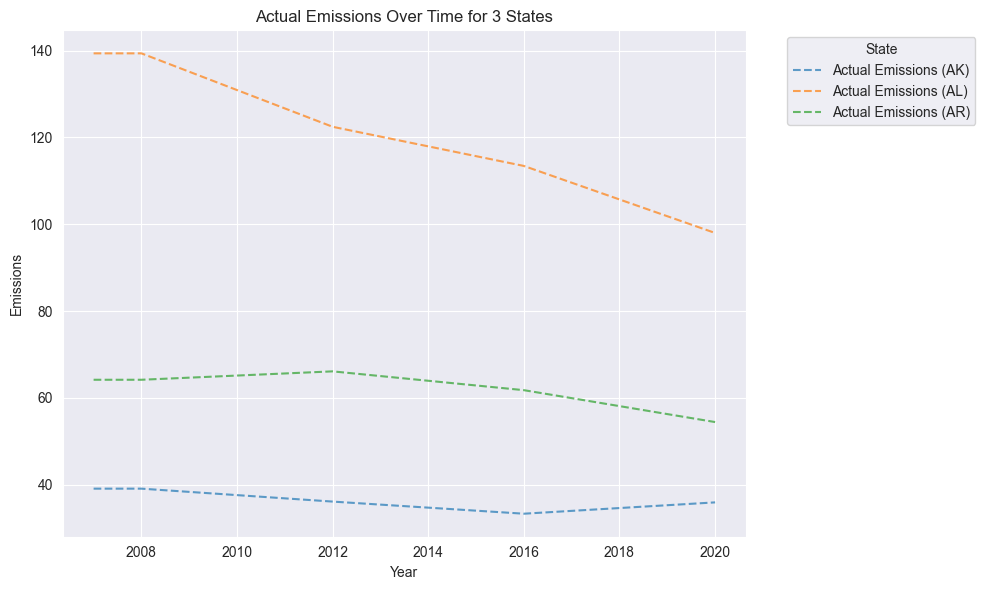

Feature: emissions_t_minus_3, Importance: 0.2054
Feature: emissions_t_minus_2, Importance: 0.1835
Feature: emissions_t_minus_1, Importance: 0.3555
Feature: Policy Scores, Importance: 0.0085
Feature: population, Importance: 0.2014
Feature: size, Importance: 0.0174
Feature: party_affiliation_score, Importance: 0.0099
Feature: state_AK, Importance: 0.0000
Feature: state_AL, Importance: 0.0000
Feature: state_AR, Importance: 0.0000
Feature: state_AZ, Importance: 0.0000
Feature: state_CA, Importance: 0.0083
Feature: state_CO, Importance: 0.0000
Feature: state_CT, Importance: 0.0000
Feature: state_DE, Importance: 0.0000
Feature: state_FL, Importance: 0.0000
Feature: state_GA, Importance: 0.0000
Feature: state_HI, Importance: 0.0000
Feature: state_IA, Importance: 0.0000
Feature: state_ID, Importance: 0.0000
Feature: state_IN, Importance: 0.0000
Feature: state_KS, Importance: 0.0000
Feature: state_KY, Importance: 0.0000
Feature: state_MA, Importance: 0.0000
Feature: state_MD, Importance: 0.0000

(0.9937386185938106,
 63.08301919547493,
                     Feature    Importance
 2       emissions_t_minus_1  3.555410e-01
 0       emissions_t_minus_3  2.053586e-01
 4                population  2.013517e-01
 1       emissions_t_minus_2  1.835457e-01
 5                      size  1.736840e-02
 37                 state_TX  9.946928e-03
 6   party_affiliation_score  9.885035e-03
 3             Policy Scores  8.495643e-03
 11                 state_CA  8.305552e-03
 40                 state_VT  1.041664e-04
 35                 state_PA  6.821403e-05
 29                 state_MT  8.057871e-06
 16                 state_GA  4.918120e-06
 32                 state_OH  2.724920e-06
 22                 state_KY  1.939350e-06
 20                 state_IN  1.685764e-06
 15                 state_FL  1.354562e-06
 30                 state_NE  1.015321e-06
 28                 state_MS  9.076747e-07
 34                 state_OR  8.118923e-07
 36                 state_TN  8.026810e-07
 27          

In [43]:
train_random_forest(final_df_dropped, 3)

### Unsupervised Analysis

This code creates a new column, "political_party," in the `final_df_imputed` DataFrame. It assigns the value 'D' (Democrat) if the "final_score_avg" is greater than 0, and 'R' (Republican) if it is less than or equal to 0. The resulting DataFrame reflects the political party assignment based on the final scores.

In [44]:
final_df_imputed_normalized['political_party'] = final_df_imputed_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_imputed_normalized

,year,Policy Scores,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,political_party
0,1976,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,D
1,1977,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,D
2,1978,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,D
3,1979,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,D
4,1980,0.385287,107.172609,-0.260609,-0.244045,0.707140,0,1,0,0,...,0,0,0,0,0,0,0,0,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,2016,-0.288220,61.035090,-0.808000,0.227085,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
2246,2017,-0.368379,59.622609,-0.808312,0.227085,-0.287553,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
2247,2018,-0.448537,58.210128,-0.808624,0.227085,-0.294644,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
2248,2019,-0.528696,56.797646,-0.808936,0.227085,-0.301735,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R


In [45]:
final_df_dropped_normalized['political_party'] = final_df_dropped_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')

final_df_dropped_normalized

,year,Policy Scores,emissions,population,size,party_affiliation_score,state_AK,state_AL,state_AR,state_AZ,...,state_PA,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WY,political_party
0,2004,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,R
1,2005,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,R
2,2006,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,R
3,2007,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,R
4,2008,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,0,1,0,0,...,0,0,0,0,0,0,0,0,0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,2016,-0.279498,61.035090,-0.788170,0.120018,-0.280461,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
625,2017,-0.329346,59.622609,-0.788426,0.120018,-0.287553,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
626,2018,-0.379194,58.210128,-0.788683,0.120018,-0.294644,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R
627,2019,-0.429043,56.797646,-0.788939,0.120018,-0.301735,0,0,0,0,...,0,0,0,0,0,0,0,0,1,R


This code processes the data by assigning political party labels based on the `party_affiliation_score` and then performs Principal Component Analysis (PCA) to reduce the data to two components, visualizing the results in a scatter plot with political party color coding. It then trains a Support Vector Machine (SVM) classifier using the two PCA components to predict political party affiliation, evaluating the model with accuracy and a confusion matrix, and visualizing the confusion matrix with a heatmap. Additionally, the code calculates and visualizes the correlation matrix for selected features to assess their relationships and calculates the Variance Inflation Factor (VIF) to check for multicollinearity among the features, providing insights into potential issues in the dataset.

In [46]:
def analyze_political_party(df):
    if 'party_affiliation_score' not in df.columns:
        df['party_affiliation_score'] = 0

    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']]
    X_scaled = StandardScaler().fit_transform(X)

    pca_result = PCA(n_components=2).fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['political_party'] = df['political_party']
    pca_df['party_affiliation_score'] = df['party_affiliation_score']

    pca_df['political_party'] = pca_df['political_party'].fillna(
        pca_df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
    )

    plt.figure(figsize=(10, 6))
    colors = {'D': 'blue', 'R': 'red'}
    plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['political_party'].apply(lambda x: colors[x]), alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Political Parties')
    plt.grid(True)
    plt.legend(['Democrat', 'Republican'])
    plt.show()

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    pca_df = pca_df.dropna(subset=['political_party'])

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_pca, y)

    y_pred = svm_model.predict(X_pca)

    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f'Accuracy: {accuracy}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Democrat', 'Republican'], yticklabels=['Democrat', 'Republican'])
    plt.title('Confusion Matrix')
    plt.show()

    correlation_matrix = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']].corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    print(vif_data)


#### Imputed

In [47]:
without_party_score_df = final_df_imputed_normalized.drop(columns='party_affiliation_score')

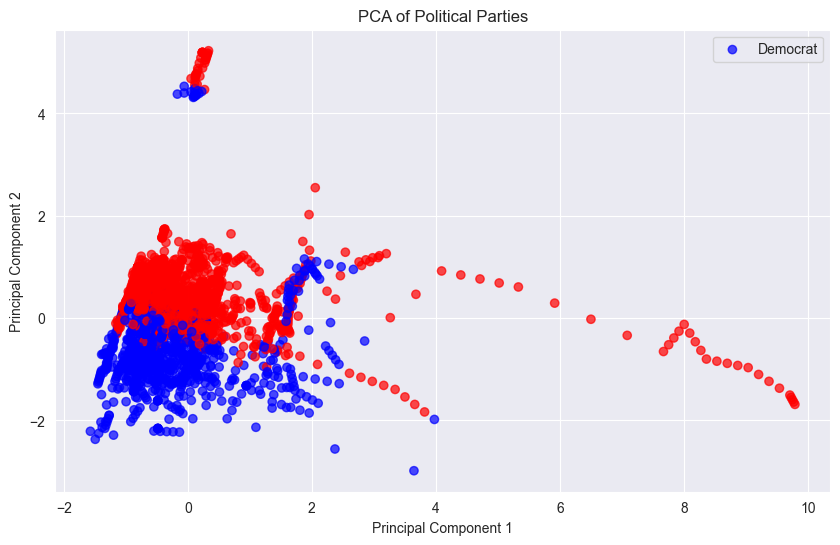

Accuracy: 0.8746666666666667


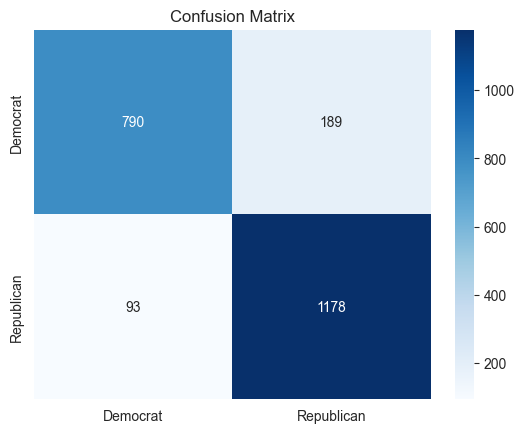

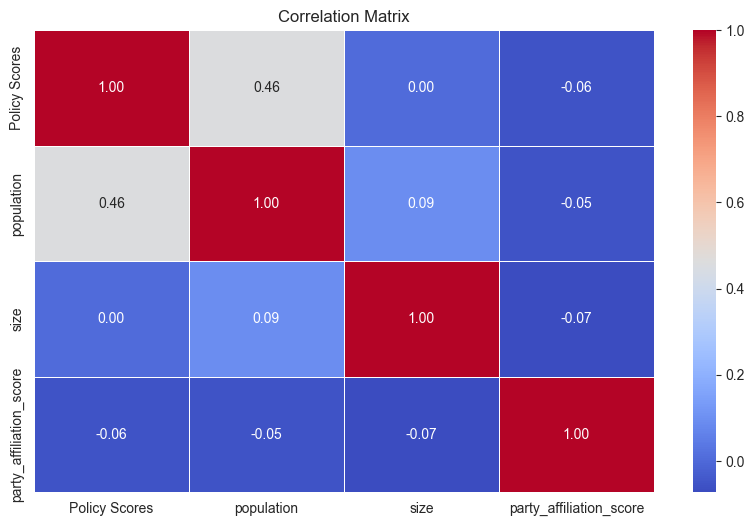

                   Feature       VIF
0                    const  1.012563
1            Policy Scores  1.268167
2               population  1.278269
3                     size  1.015748
4  party_affiliation_score  1.008898


In [48]:
analyze_political_party(final_df_imputed_normalized)

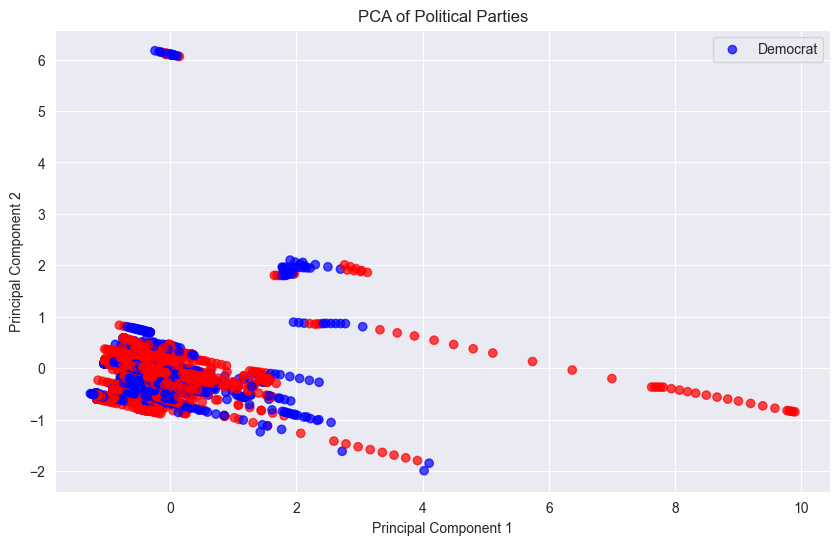

Accuracy: 0.5648888888888889


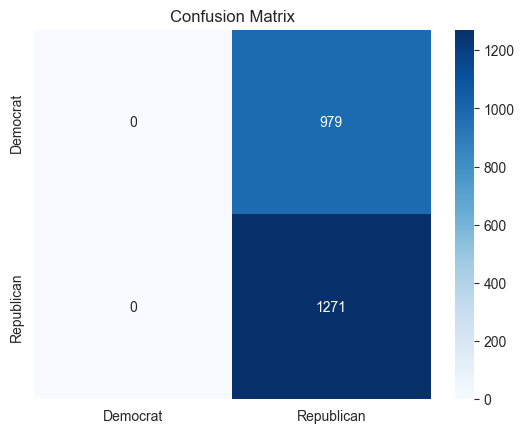

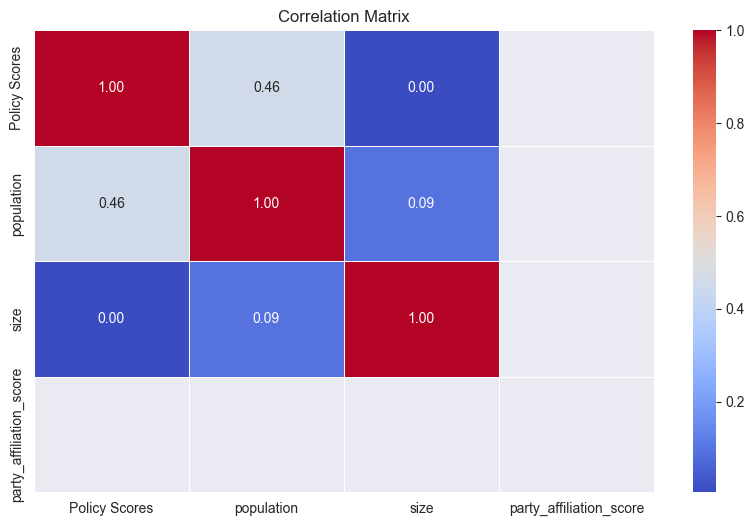

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.266308
2               population  1.277582
3                     size  1.010805
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [49]:
analyze_political_party(without_party_score_df)

#### Non-imputed

In [50]:
without_party_score_df = final_df_dropped_normalized.drop(columns='party_affiliation_score')

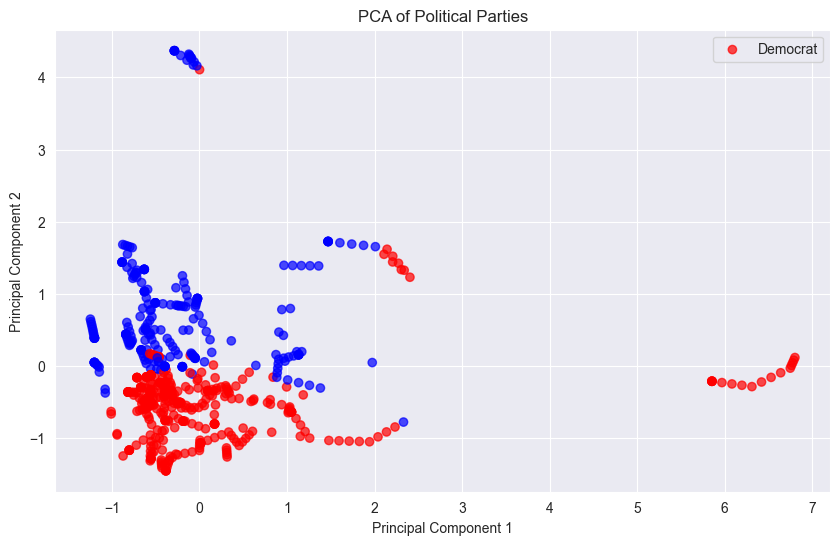

Accuracy: 0.9236883942766295


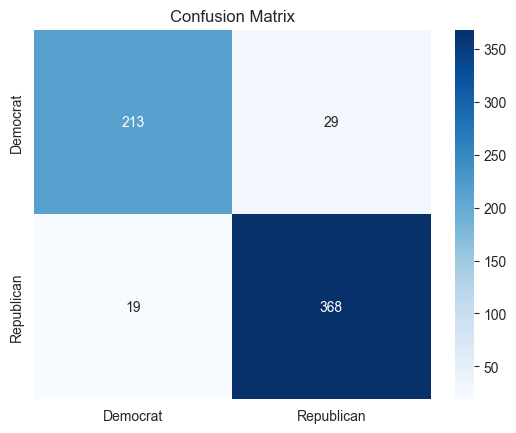

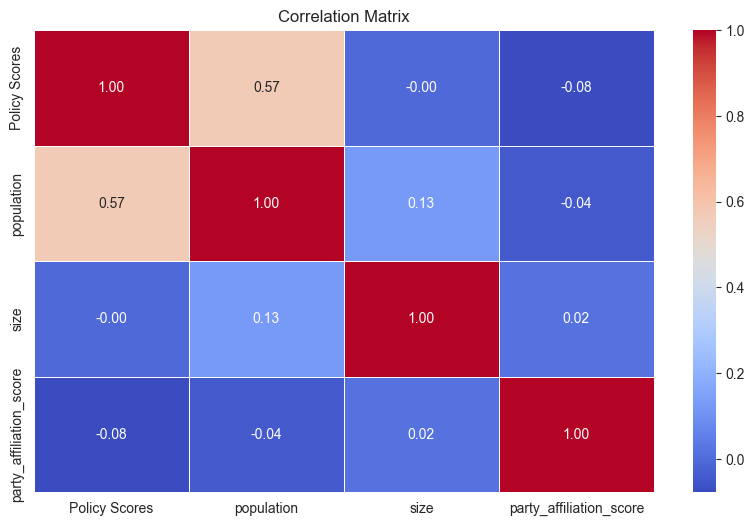

                   Feature       VIF
0                    const  1.035322
1            Policy Scores  1.491595
2               population  1.509379
3                     size  1.024679
4  party_affiliation_score  1.006232


In [51]:
analyze_political_party(final_df_dropped_normalized)

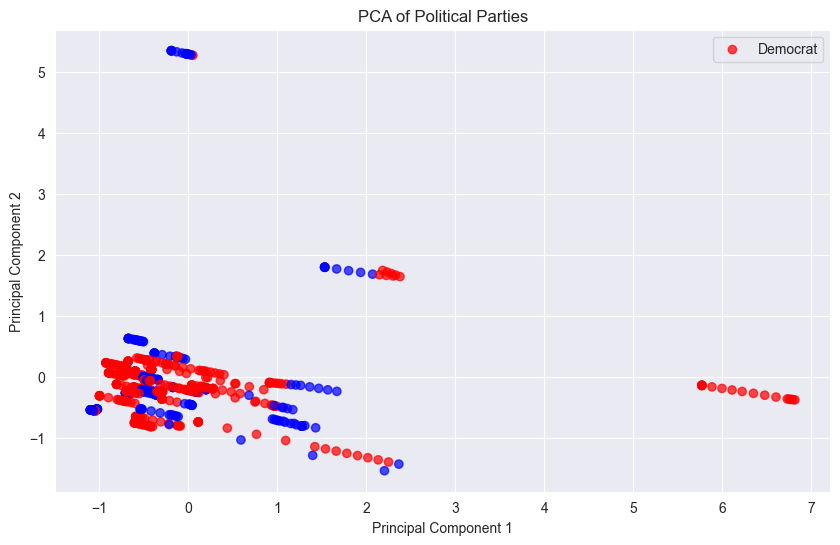

Accuracy: 0.6391096979332274


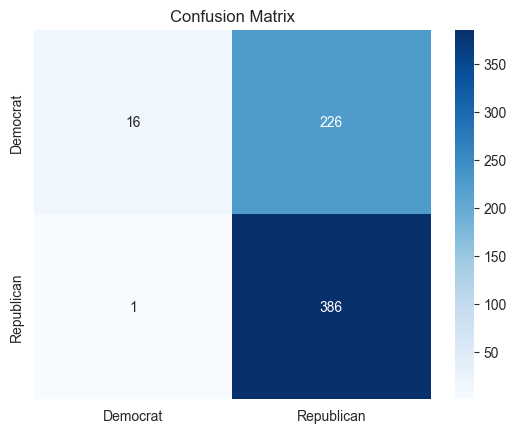

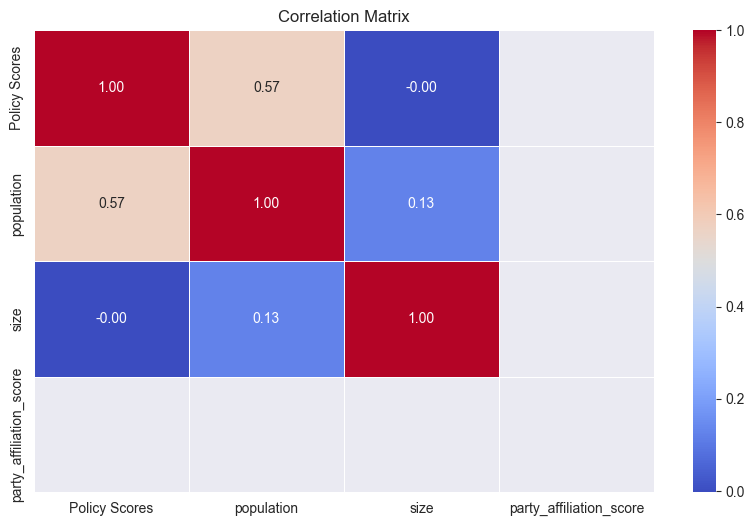

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.485577
2               population  1.509379
3                     size  1.024433
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [52]:
analyze_political_party(without_party_score_df)